In [2]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_symmetric
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering, k_means
from sklearn.manifold import spectral_embedding

from graspologic.plot import adjplot
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed   
from graspologic.utils import remap_labels, is_symmetric
from graspologic.simulations import sbm

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_sims = 50
n_verts = [500, 1000, 5000, 10000, 20000]

#n_sims = 100
#n_verts = [500, 1000, 5000, 10000, 20000, 40000]

B_aff = np.array([[0.050, 0.013], [0.013, 0.051]])
B_core = np.array([[0.011, 0.027], [0.027, 0.079]])

In [4]:
def calc_ari(B, embed_method):
    rows = []
    for n in n_verts:
        #generate the true labels
        labels_sbm = n * [0] + n * [1]

        #generate the sbm
        sampled_sbm = sbm(2 * [n], B, directed=True)

        for _ in range(n_sims):
            #choose embedding method
            if embed_method == "ase":
                ase = AdjacencySpectralEmbed(n_components=2)
                Xhat, Yhat = ase.fit_transform(sampled_sbm)
            elif embed_method == "lse":
                lse = LaplacianSpectralEmbed(n_components=2)
                Xhat, Yhat = lse.fit_transform(sampled_sbm)
            elif embed_method == "sklearn":
                Xhat = spectral_embedding(sampled_sbm, n_components=2)

            #calculate the ari score
            labels_kmeans = KMeans(n_clusters=2).fit_predict(Xhat)
            ari = adjusted_rand_score(labels_sbm, labels_kmeans)
            result = {
                "test": embed_method,
                "n_vert": n,
                "ari": ari
            }
            rows.append(result)

    results = pd.DataFrame(rows)
    return results

In [5]:
#lse vs sklearn (use B_aff)
ari_aff_lse_df = calc_ari(B = B_aff, embed_method = "lse")
ari_aff_sklearn_df = calc_ari(B = B_aff, embed_method = "sklearn")
ari_aff_df = pd.concat([ari_aff_lse_df, ari_aff_sklearn_df])
ari_aff_df.to_csv("ari_aff_df.csv")

In [ ]:
#get the means across the sims (groupby test and n_vert)
ari_aff_means = ari_aff_df.groupby(["test", "n_vert"]).mean()
ari_aff_means

ari
test    n_vert          
lse     500     1.000000
        1000    1.000000
sklearn 500     0.899944
        1000    0.899972

Text(0.5, 1.0, 'ARI of Affinity Graph using LSE and Sklearn Embedding')

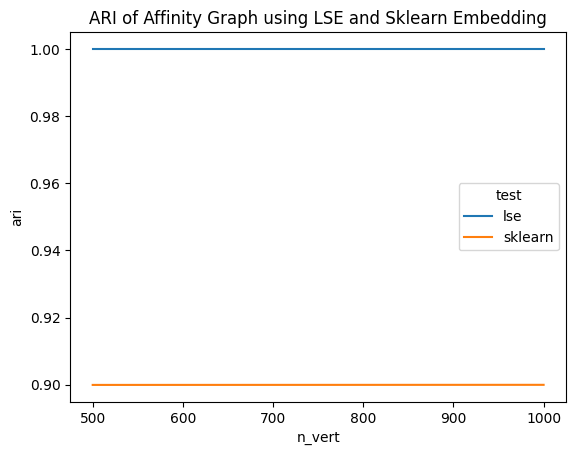

In [ ]:
#make lse vs sklearn affinity plot
sns.lineplot(data=ari_aff_df, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Affinity Graph using LSE and Sklearn Embedding')

In [ ]:
#ase vs sklearn (use B_core)
ari_core_ase_df = calc_ari(B = B_core, embed_method = "ase")
ari_core_sklearn_df = calc_ari(B = B_core, embed_method = "sklearn")
ari_core_df = pd.concat([ari_core_ase_df, ari_core_sklearn_df])
ari_core_df.to_csv("ari_core_df.csv")

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/li

In [ ]:
#get the means across the sims (groupby test and n_vert)
ari_core_means = ari_core_df.groupby(["test", "n_vert"]).mean()
ari_core_means

ari
test    n_vert          
ase     500     0.601873
        1000    0.998000
sklearn 500     0.001947
        1000    0.000338

Text(0.5, 1.0, 'ARI of Core Periphery Graph using ASE and Sklearn Embedding')

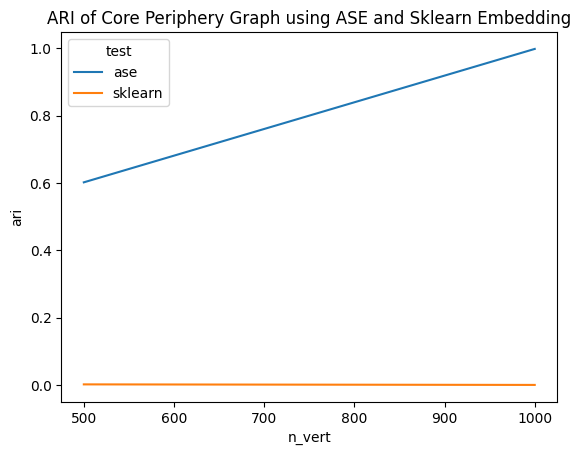

In [ ]:
#make ase vs sklearn core periphery plot
sns.lineplot(data=ari_core_df, x="n_vert", y="ari", hue="test", errorbar=None)
plt.title('ARI of Core Periphery Graph using ASE and Sklearn Embedding')